In [5]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [6]:
# Generate a dataset
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(5000, noise=0.20)
train_y_onehot = np.eye(2)[train_y]

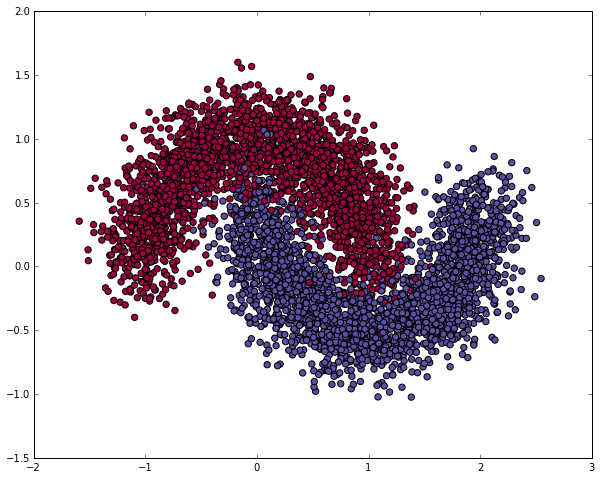

In [11]:
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral);

In [18]:
class NeuralNetTheano(object):
    def __init__(self, input_dim, output_dim, nn_hdim, X, y, epsilon, reg_lambda):
        self.nn_input_dim = input_dim # input layer dimensionality
        self.nn_output_dim = output_dim # output layer dimensionality
    
        X = theano.shared(train_X.astype('float32')) # initialized on the GPU
        y = theano.shared(train_y_onehot.astype('float32'))

        # GPU NOTE: Conversion to float32 to store them on the GPU!
        W1 = theano.shared(np.random.randn(self.nn_input_dim, nn_hdim).astype('float32'), name='W1')
        b1 = theano.shared(np.zeros(nn_hdim).astype('float32'), name='b1')
        W2 = theano.shared(np.random.randn(nn_hdim, self.nn_output_dim).astype('float32'), name='W2')
        b2 = theano.shared(np.zeros(self.nn_output_dim).astype('float32'), name='b2')

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = T.tanh(z1)
        z2 = a1.dot(W2) + b2
        y_hat = T.nnet.softmax(z2)

        # The regularization term (optional)
        loss_reg = 1./len(X) * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
        # the loss function we want to optimize
        loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg
        # Returns a class prediction
        prediction = T.argmax(y_hat, axis=1)

        # Gradients
        dW2 = T.grad(loss, W2)
        db2 = T.grad(loss, b2)
        dW1 = T.grad(loss, W1)
        db1 = T.grad(loss, b1)

        # Note that we removed the input values because we will always use the same shared variable
        # GPU NOTE: Removed the input values to avoid copying data to the GPU.
        forward_prop = theano.function([], y_hat)
        calculate_loss = theano.function([], loss)
        predict = theano.function([], prediction)

        # GPU NOTE: Removed the input values to avoid copying data to the GPU.
        gradient_step = theano.function(
            [],
            # profile=True,
            updates=((W2, W2 - epsilon * dW2),
                     (W1, W1 - epsilon * dW1),
                     (b2, b2 - epsilon * db2),
                     (b1, b1 - epsilon * db1)))
        
        def build_model(num_passes=20000, print_loss=False):
            # Re-Initialize the parameters to random values. We need to learn these.
            np.random.seed(0)
            # GPU NOTE: Conversion to float32 to store them on the GPU!
            W1.set_value((np.random.randn(self.nn_input_dim, nn_hdim) / np.sqrt(self.nn_input_dim)).astype('float32'))
            b1.set_value(np.zeros(nn_hdim).astype('float32'))
            W2.set_value((np.random.randn(nn_hdim, self.nn_output_dim) / np.sqrt(nn_hdim)).astype('float32'))
            b2.set_value(np.zeros(self.nn_output_dim).astype('float32'))

            # Gradient descent. For each batch...
            for i in xrange(0, num_passes):
                # This will update our parameters W2, b2, W1 and b1!
                gradient_step()

                # Optionally print the loss.
                # This is expensive because it uses the whole dataset, so we don't want to do it too often.
                if print_loss and i % 1000 == 0:
                    print "Loss after iteration %i: %f" %(i, calculate_loss())



        return self.model

In [19]:
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 1000 # hiden layer dimensionality

# Gradient descent parameters
epsilon = np.float32(0.01) # learning rate for gradient descent
reg_lambda = np.float32(0.01) # regularization strength 

In [20]:
NNT = NeuralNetTheano(nn_input_dim, nn_output_dim, nn_hdim, X_train, y_train, epsilon, reg_lambda)
NNT.build_model(print_loss=True)

TypeError: object of type 'TensorSharedVariable' has no len()